# Model Implementation of Venomous and Non-venomous Snakes

---

1. Install Dependencies and Setup

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, KFold
from keras.applications import ResNet50, VGG16, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [43]:
data_dir = r'C:\Users\ivanne bayer\Desktop\Computer Science\Comp Sci - Yr. 3 second sem\CS 3201 - Thesis 1\CS 3201 - Implementation\placeholder_test'

2. Performing EDA

In [44]:
venomous_dir = os.path.join(data_dir, 'venomous')
non_venomous_dir = os.path.join(data_dir, 'non_venomous')

num_venomous = len([f for f in os.listdir(venomous_dir) if os.path.isfile(os.path.join(venomous_dir, f))])
num_non_venomous = len([f for f in os.listdir(non_venomous_dir) if os.path.isfile(os.path.join(non_venomous_dir, f))])

print("Number of Snakes collected")
print("Venomous: " + str(num_venomous))
print("Non-Venomous: " + str(num_non_venomous))

Number of Snakes collected
Venomous: 86
Non-Venomous: 85


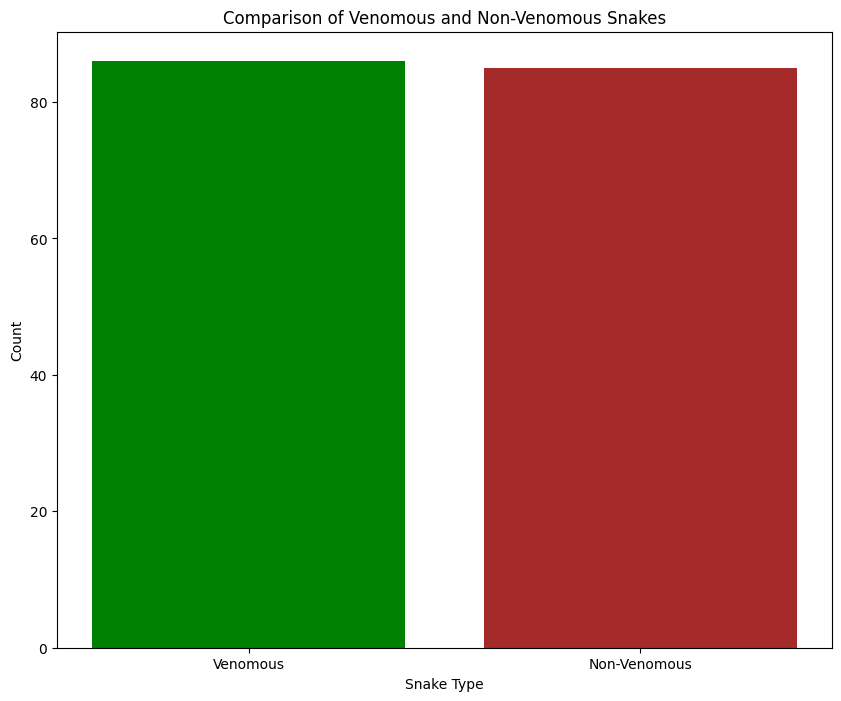

In [45]:
categories = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.figure(figsize=(10, 8))
plt.bar(categories, counts, color=['green', 'brown'])
plt.xlabel('Snake Type')
plt.ylabel('Count')
plt.title('Comparison of Venomous and Non-Venomous Snakes')
plt.show()

3. Preprocessing the Images

In [46]:
def load_images_and_labels(data_dir):
    # Label 0 if venomous
    # Label 1 if non-venomous
    X = []
    y = []

    for label, folder in enumerate(['venomous', 'non_venomous']):
        folder_path = os.path.join(data_dir, folder)
        images_in_folder = os.listdir(folder_path)

        for file in images_in_folder:
            file_path = os.path.join(folder_path, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (224, 224))  # Resizing images to 224x224
            image = image.astype('float32') / 255.0  # Normalization to values [0,1]
            X.append(image)
            y.append(label)

        # For venomous snakes, duplicate the images and add augmentation
        # if folder == 'venomous':
        #     venomous_images = X[-len(images_in_folder):]  # Get the original venomous images

        #     # Data augmentation for the duplicated images
        #     datagen = ImageDataGenerator(
        #         horizontal_flip=True,
        #         zoom_range=0.3
        #     )
            
        #     for image in venomous_images:
        #         augmented_image = datagen.random_transform(image)
                
        #         X.append(augmented_image)
        #         y.append(label)

    return np.array(X), np.array(y)

4. Training and Testing Split

In [47]:
X, y = load_images_and_labels(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Should be 6,484 images total
print("Number of images for training:", len(X_train))
print("Number of images for testing:", len(X_test))

Number of images for training: 136
Number of images for testing: 35


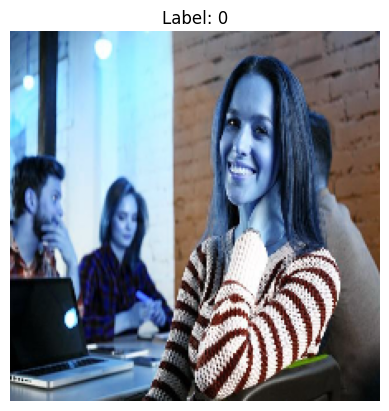

In [48]:
idx = np.random.randint(len(X_train))
image = X_train[idx]
label = y_train[idx]
plt.imshow(image)
plt.title('Label: ' + str(label))
plt.axis('off')
plt.show()

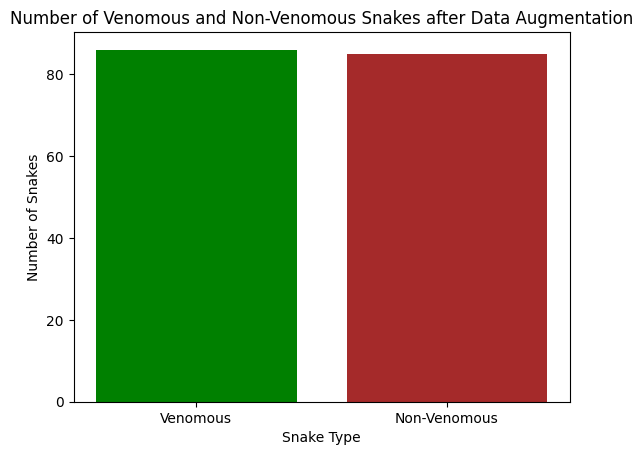

In [49]:
num_venomous = np.sum(y == 0)
num_non_venomous = np.sum(y == 1)

labels = ['Venomous', 'Non-Venomous']
counts = [num_venomous, num_non_venomous]

plt.bar(labels, counts, color=['green', 'brown'])
plt.xlabel('Snake Type')
plt.ylabel('Number of Snakes')
plt.title('Number of Venomous and Non-Venomous Snakes after Data Augmentation')
plt.show()

5. Creating the Models

In [50]:
def create_model(model_name):
    if model_name == 'ResNet50':
        base_model = ResNet50(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'VGG16':
        base_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 256
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        dense_units = 512
        for layer in base_model.layers:
            layer.trainable = False
        num_layers_to_unfreeze = int(0.10 * len(base_model.layers))
        for layer in base_model.layers[-num_layers_to_unfreeze:]:
            layer.trainable = True
    
    pretrained_model = Sequential([
        base_model,
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return pretrained_model

6. Evaluating the Models

In [54]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training the model...")
    history = model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    print("Training finished.")
    
    print("Evaluating the model on test data...")
    _, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Evaluation finished.")
    
    return history, accuracy

7. Train the Models and Identify Mean Performance of each Algorithm

Training and evaluating ResNet50
Training the model...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5810 - loss: 1.0520 - val_accuracy: 0.5143 - val_loss: 0.7951
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6762 - loss: 0.6529 - val_accuracy: 0.5143 - val_loss: 4.8968
Training finished.
Evaluating the model on test data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5199 - loss: 4.8315
Evaluation finished.


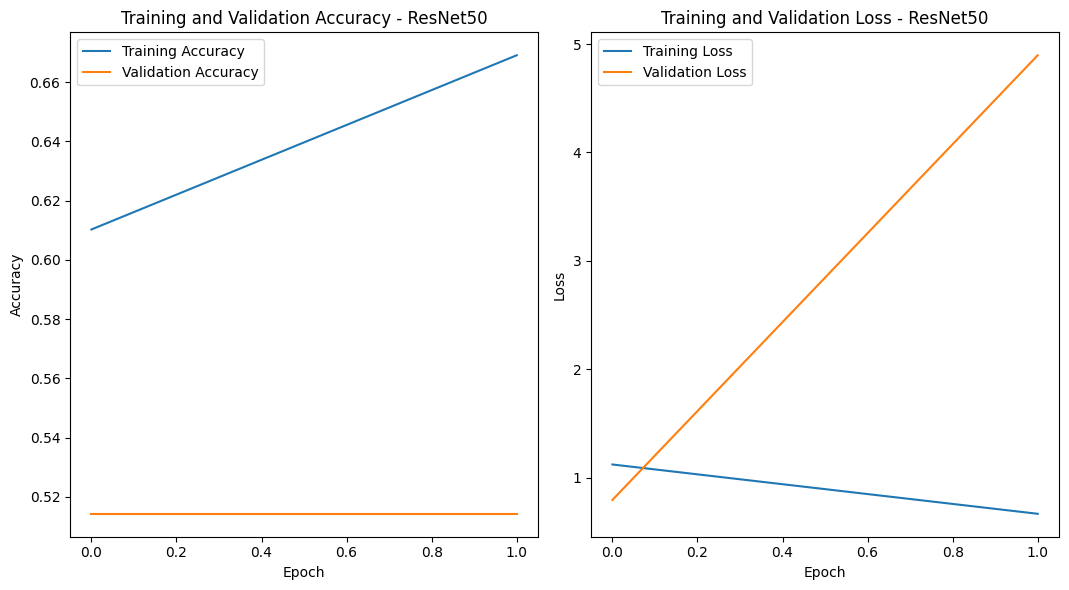

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


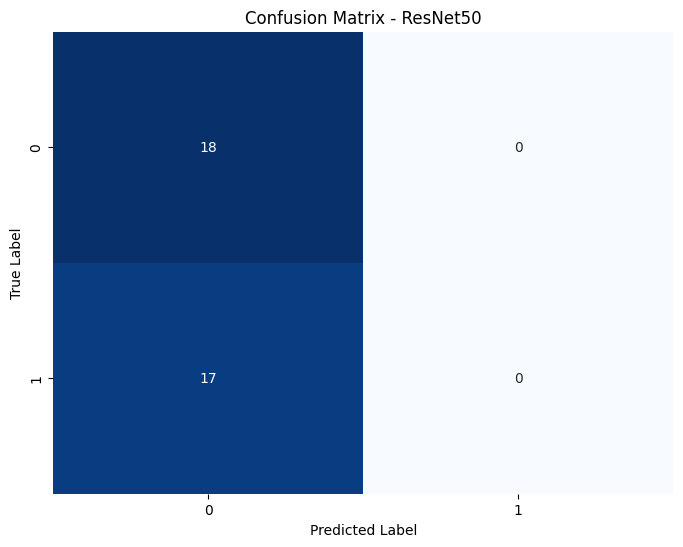

Classification Report for ResNet50
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        18
           1       0.00      0.00      0.00        17

    accuracy                           0.51        35
   macro avg       0.26      0.50      0.34        35
weighted avg       0.26      0.51      0.35        35

Training and evaluating VGG16
Training the model...
Epoch 1/2


c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4562 - loss: 0.7259 - val_accuracy: 0.8286 - val_loss: 0.6233
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8643 - loss: 0.6048 - val_accuracy: 0.8286 - val_loss: 0.5579
Training finished.
Evaluating the model on test data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.8336 - loss: 0.5575
Evaluation finished.


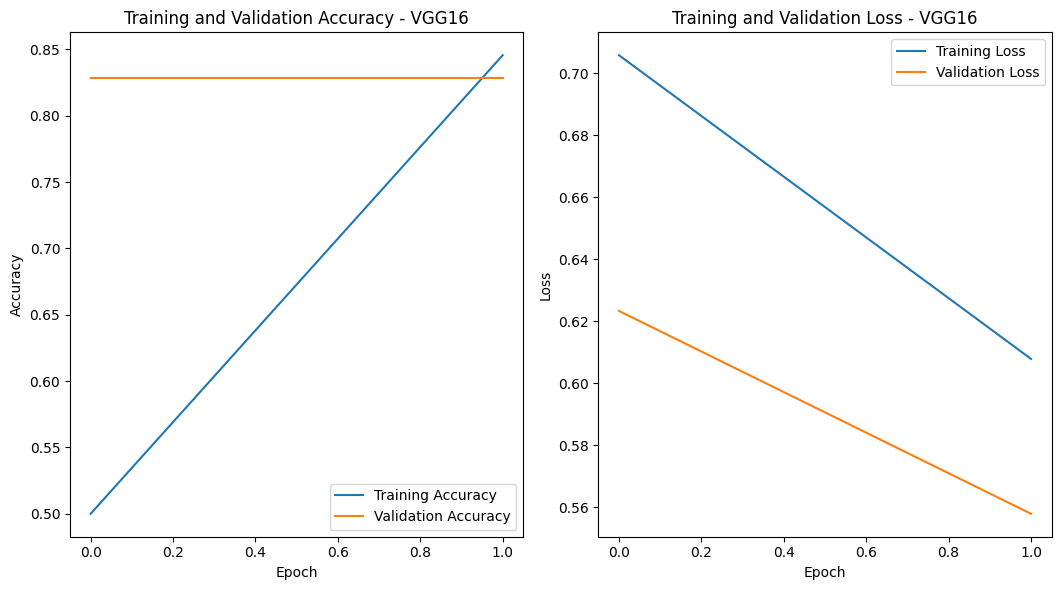

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step


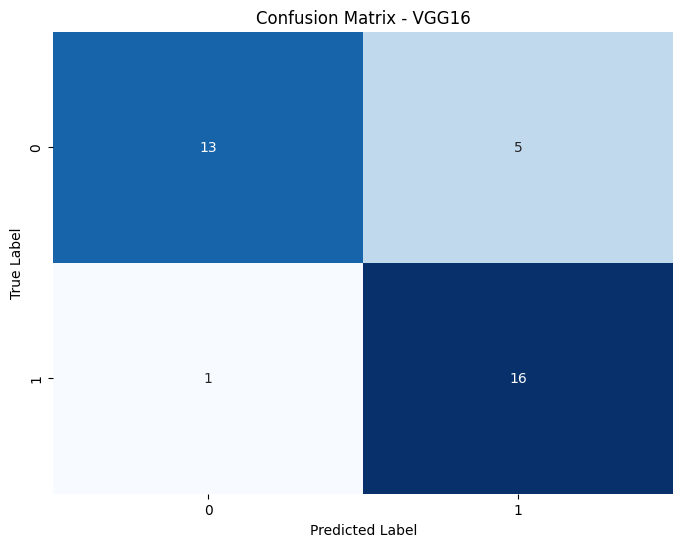

Classification Report for VGG16
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.76      0.94      0.84        17

    accuracy                           0.83        35
   macro avg       0.85      0.83      0.83        35
weighted avg       0.85      0.83      0.83        35

Training and evaluating DenseNet201
Training the model...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7133 - loss: 0.5502 - val_accuracy: 0.8857 - val_loss: 0.4328
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9340 - loss: 0.1390 - val_accuracy: 0.8286 - val_loss: 0.8532
Training finished.
Evaluating the model on test data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.8232 - loss: 0.8797
Evaluation finished.


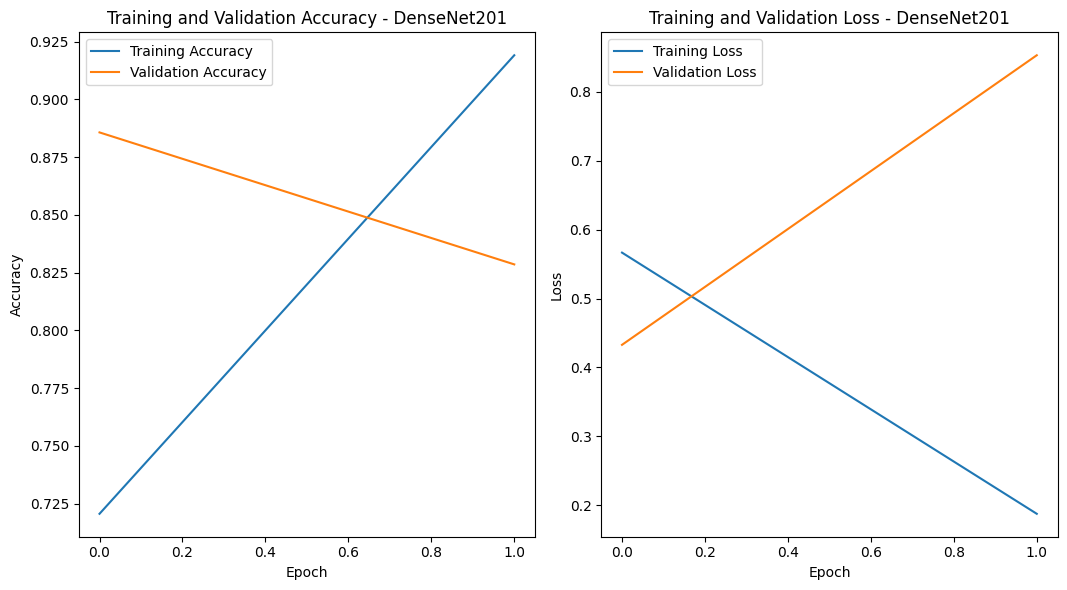

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step


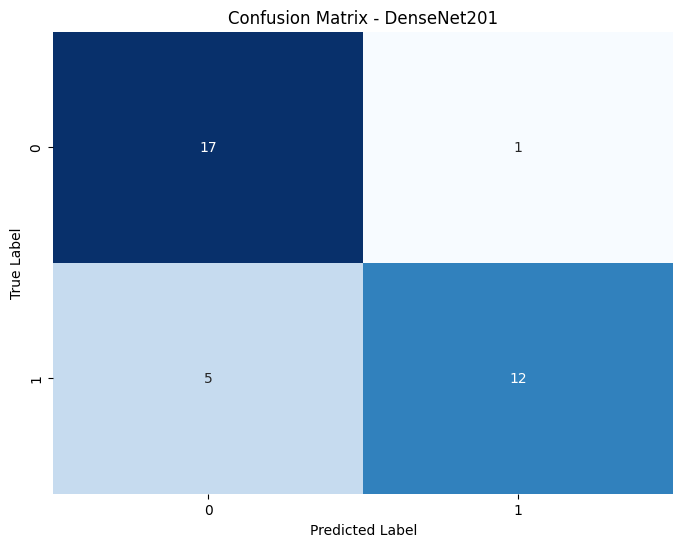

Classification Report for DenseNet201
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.92      0.71      0.80        17

    accuracy                           0.83        35
   macro avg       0.85      0.83      0.82        35
weighted avg       0.85      0.83      0.83        35



In [57]:
models = {'ResNet50': create_model('ResNet50'), 'VGG16': create_model('VGG16'), 'DenseNet201': create_model('DenseNet201')}
accuracies = {}

for name, model in models.items():
    print("Training and evaluating", name)
    history, accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
    accuracies[name] = accuracy
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - ' + name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss - ' + name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix - ' + name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Classification Report for", name)
    print(classification_report(y_test, y_pred, zero_division='warn'))

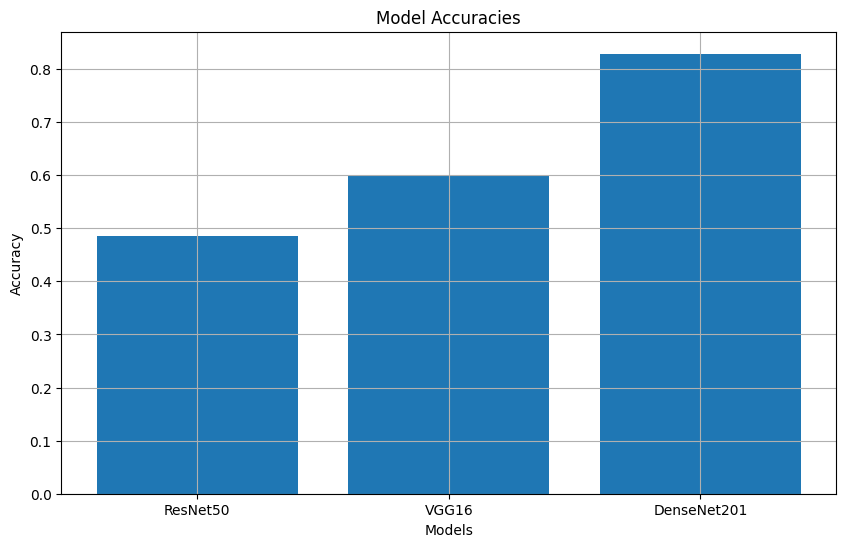

In [ ]:
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.grid(True)
plt.show()